# Modeling spatial point patterns with a marked log-Gaussian Cox process

## Introduction

The log-Gaussian Cox process (LGCP) is a probabilistic model of point patterns typically observed in space or time. It has two main components. First, an underlying *intensity* field $\lambda(s)$ of positive real values is modeled over the entire domain $X$ using an exponentially-transformed Gaussian process which constraints $\lambda$ to be positive. Then, this intensity field is used to parameterize a [Poisson point process](https://en.wikipedia.org/wiki/Poisson_point_process) which represents a stochastic mechanism for placing points in space. Some phenomena amenable to this representation include the incidence of cancer cases across a county, or the spatiotemporal locations of crime events in a city. Both spatial and temporal dimensions can be handled equivalently within this framework, though this tutorial only addresses data in two spatial dimensions.

In more formal terms, if we have a space $X$ and $A\subseteq X$, the distribution over the number of points $Y_A$ occurring within subset $A$ is given by
$$Y_A \sim Poisson\left(\int_A \lambda(s) ds\right)$$
and the intensity field is defined as
$$\log \lambda(s) \sim GP(\mu(s), K(s,s'))$$
where $GP(\mu(s), K(s,s'))$ denotes a Gaussian process with mean function $\mu(s)$ and covariance kernel $K(s,s')$ for a location $s \in X$. This is one of the simplest models of point patterns of $n$ events recorded as locations $s_1,...,s_n$ in an arbitrary space. In conjunction with a Bayesian analysis, can be used to answering questions of interest such as:
* Does an observed point pattern imply a statistically significant shift in spatial intensities?
* What would randomly sampled patterns with the same statistical properties look like?
* Is there a statistical correlation between the *frequency* and *magnitude* of point events?

In this notebook, we'll use a grid-based approximation to the full LGCP with PyMC3 to fit a model and analyze its posterior summaries. We will also explore the usage of a marked Poisson process, an extension of this model to account for the distribution of *marks* associated with each data point.


## Data

Our observational data concerns 231 sea anemones whose sizes and locations on the French coast were recorded. This data was taken from the [`spatstat` spatial modeling package in R](https://github.com/spatstat/spatstat) which is designed to address models like the LGCP and its subsequent refinements. The original source of this data is the textbook *Spatial data analysis by example* by Upton and Fingleton (1985) and a longer description of the data can be found there. 


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [3]:
data = pd.read_csv(pm.get_data("anemones.csv"))
n = data.shape[0]

This dataset has coordinates and discrete mark values for each anemone. While these marks are integers, for the sake of simplicity we will model these values as continuous in a later step.

In [4]:
data.head(3)

,x,y,marks
0,27,7,6
1,197,5,4
2,74,15,4


Let's take a look at this data in 2D space:

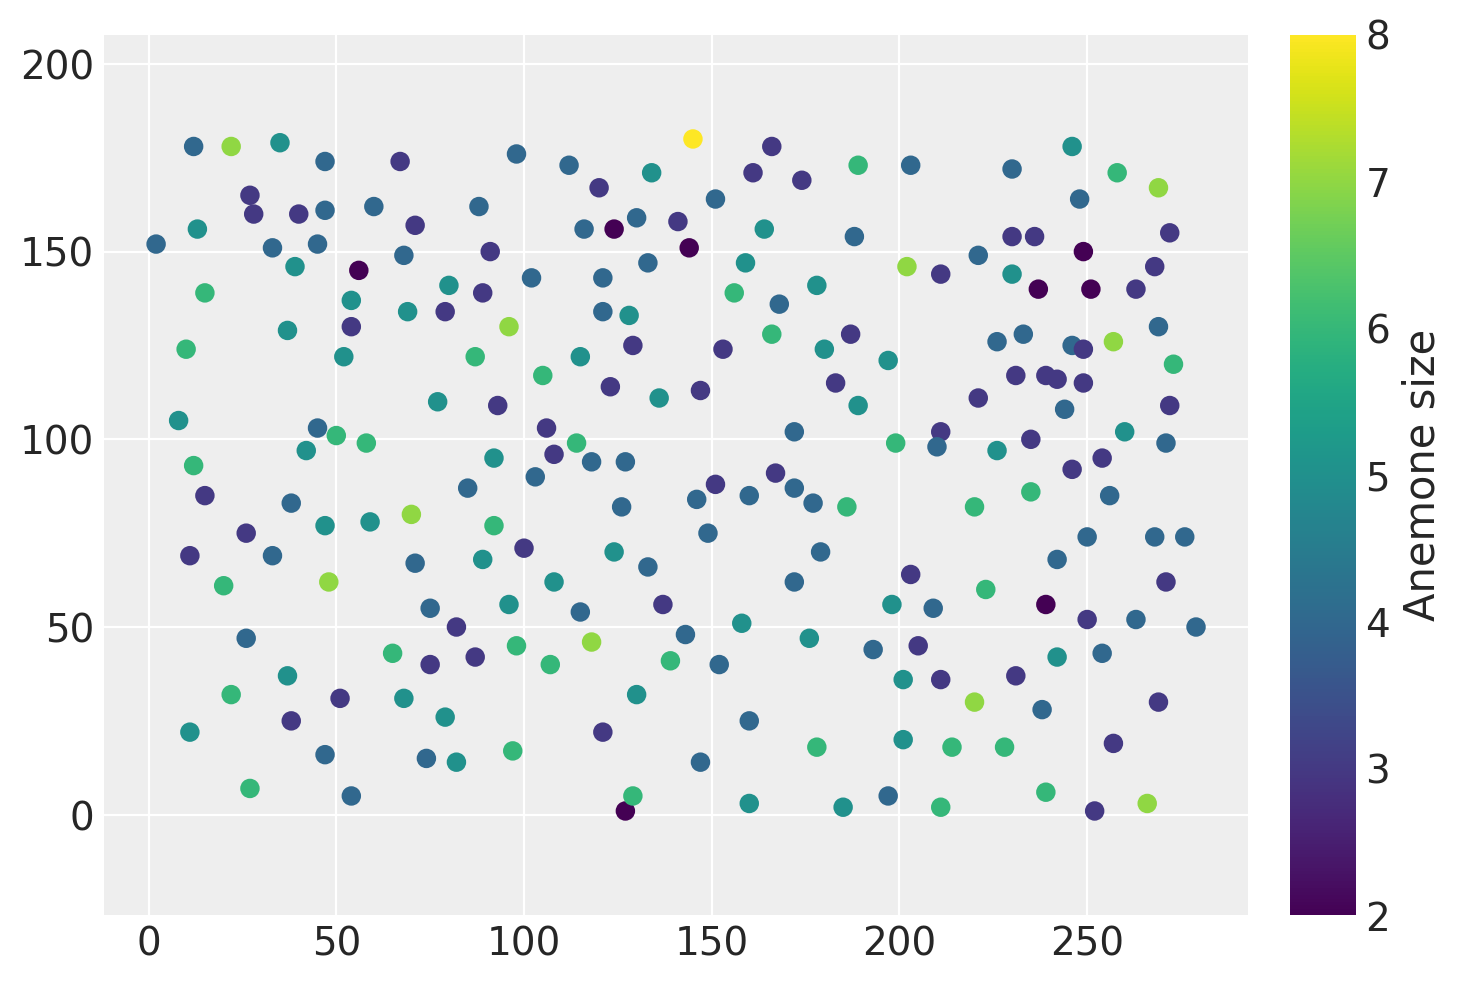

In [5]:
plt.scatter(data["x"], data["y"], c=data["marks"]),
plt.colorbar(label="Anemone size"), plt.axis("equal");

The 'marks' column indicates the size of each anemone. If we were to model both the marks and the spatial distribution of points, we would be modeling a *marked Poisson point process*. Extending the basic point pattern model to include this feature is the second portion of this notebook.

While there are multiple ways to conduct inference, perhaps the  simplest way is to slice up our domain $X$ into many small pieces $A_1, A_2,...,A_M$ and fix the intensity field to be constant within each subset. Then, we will treat the number of points within each $A_j$ as a Poisson random variable such that $Y_j \sim Poisson(\lambda_j)$. and we also consider the $\log{\lambda_1}...,\log{\lambda_M}$ variables as a single draw from a Gaussian process.

The code below splits up the domain into grid cells, counts the number of points within each cell and also identifies its centroid.

In [6]:
xy = data[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e-3
xy = xy.astype("float") + np.random.randn(*xy.shape) * eps

resolution = 20

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution ** 2 / 100

cells_x = int(280 / resolution)
cells_y = int(180 / resolution)
quadrat_x = np.linspace(0, 280, cells_x + 1)
quadrat_y = np.linspace(0, 180, cells_y + 1)

cell_counts = []
centroids = []

for i in range(1, cells_x + 1):
    for j in range(1, cells_y + 1):
        cell_left, cell_right = quadrat_x[i - 1], quadrat_x[i]
        cell_bottom, cell_top = quadrat_y[j - 1], quadrat_y[j]

        centroids.append([(cell_left + cell_right) / 2, (cell_bottom + cell_top) / 2])

        in_x_cell = (xy[:, 0] >= cell_left) & (xy[:, 0] < cell_right)
        in_y_cell = (xy[:, 1] >= cell_bottom) & (xy[:, 1] < cell_top)

        is_point_in_cell = in_x_cell & in_y_cell
        cell_counts.append(xy[is_point_in_cell].shape[0])

cell_counts = np.asarray(cell_counts)
centroids = np.asarray(centroids)

With the points split into different cells and the cell centroids computed, we can plot our new gridded dataset as shown below.

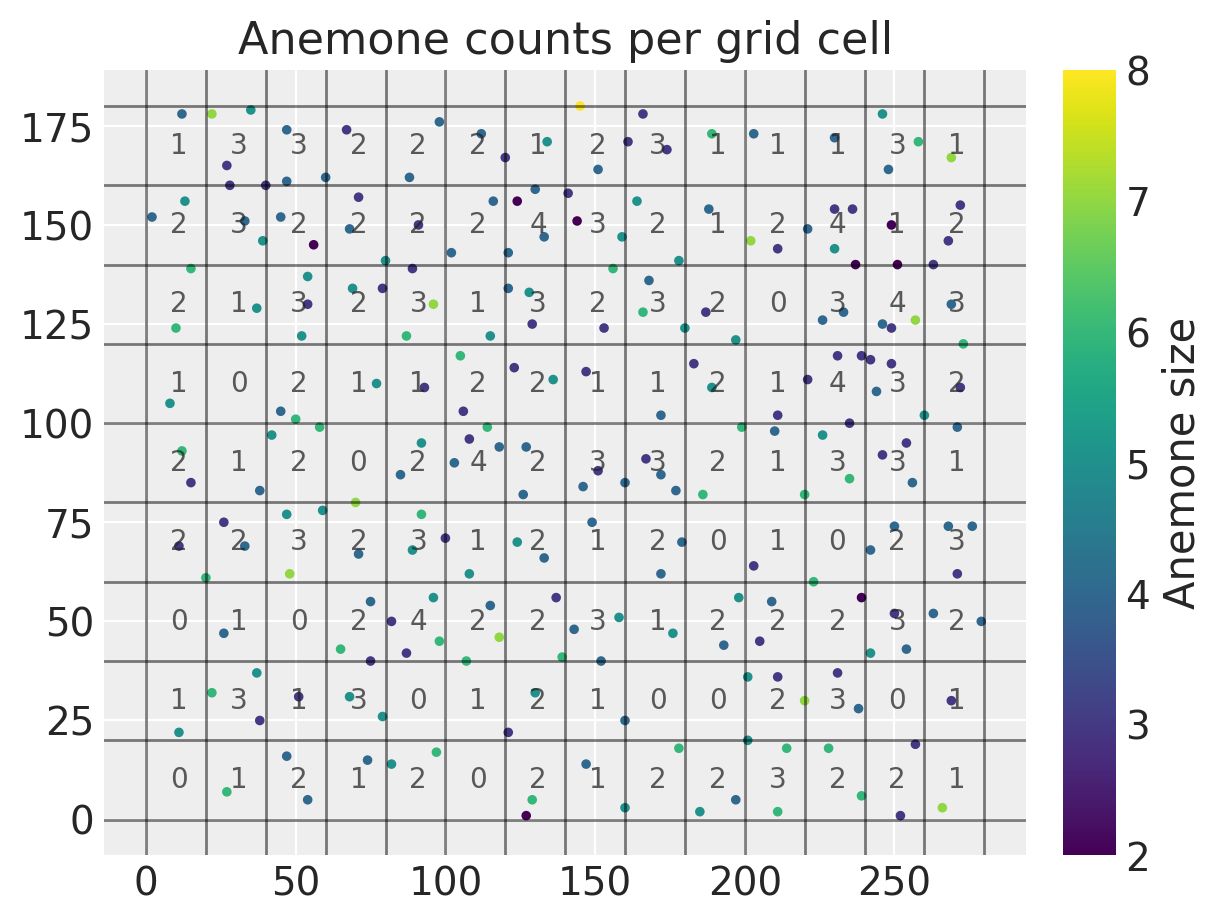

In [7]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data["x"], data["y"], c=data["marks"], s=6)

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Anemone counts per grid cell"), plt.colorbar(label="Anemone size");

We can see that all of the counts are fairly low and range from zero to five. With all of our data prepared, we can go ahead and start writing out our probabilistic model in PyMC3. We are going to treat each of the per-cell counts $Y_1,...Y_M$ above as a Poisson random variable.

# Inference

Our first step is to place prior distributions over the high-level parameters for the Gaussian process. This includes the length scale for the covariance function and a constant mean for the GP.

In [8]:
with pm.Model() as lgcp_model:
    lam_mean = pm.Normal("lam_mean", sd=10)
    length_scale = pm.Uniform("length_scale", lower=0.1, upper=280)
    cov_scale = pm.Exponential("scale", lam=1)

    cov_func = cov_scale * pm.gp.cov.ExpQuad(2, ls=length_scale)
    mean_func = pm.gp.mean.Constant(lam_mean)

Next, we transform the Gaussian process into a positive-valued process via `pm.math.exp` and use the area per cell to transform the intensity function $\lambda(s)$ into rates $\lambda_i$ parameterizing the Poisson likelihood for the counts within cell $i$.

In [9]:
with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)

    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

With the model fully specified, we can start sampling from the posterior using the default NUTS sampler. I'll also tweak the target acceptance rate to reduce the number of divergences.

In [10]:
with lgcp_model:
    trace = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_intensity_rotated_, scale, length_scale, lam_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1022 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


# Interpreting the results

Posterior inference on the `length_scale` parameter is useful for understanding whether or not there are long-range correlations in the data. We can also examine the mean of the log-intensity field, but since it is on the log scale it is hard to directly interpret.

In [11]:
with lgcp_model:
    summary_lgcp = pm.summary(trace, var_names=["lam_mean", "length_scale"])
summary_lgcp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_mean,-0.899,0.488,-2.007,0.025,0.018,0.015,776.0,527.0,1042.0,603.0,1.0
length_scale,201.461,62.511,83.664,279.768,1.624,1.149,1482.0,1482.0,1459.0,979.0,1.0


We are also interested in looking at the value of the intensity field at a large number of new points in space. We can accomodate this within our model by including a new random variable for the latent Gaussian process evaluated at a denser set of points. Using `sample_posterior_predictive`, we generate posterior predictions on new data points contained in the variable `intensity_new`.

In [12]:
x_new = np.linspace(5, 275, 20)
y_new = np.linspace(5, 175, 20)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    intensity_new = gp.conditional("intensity_new", Xnew=xy_new)
    new_samples = pm.sample_posterior_predictive(trace, vars=[intensity_new])

Due to numerical issues, a few of the Gaussian process samples in `new_samples` will have NaN values. We can filter them out with a one line statement.

In [13]:
intensity_samples = np.asarray(
    [x for x in new_samples["intensity_new"] if np.all(np.isfinite(x))]
)

Let's take a look at a few realizations of $\lambda(s)$. Since the samples are on the log scale, we'll need to exponentiate them to obtain the spatial intensity field of our 2D Poisson process. In the plot below, the observed point pattern is overlaid.

<ipython-input-14-b1eb56dee2c6>:24: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


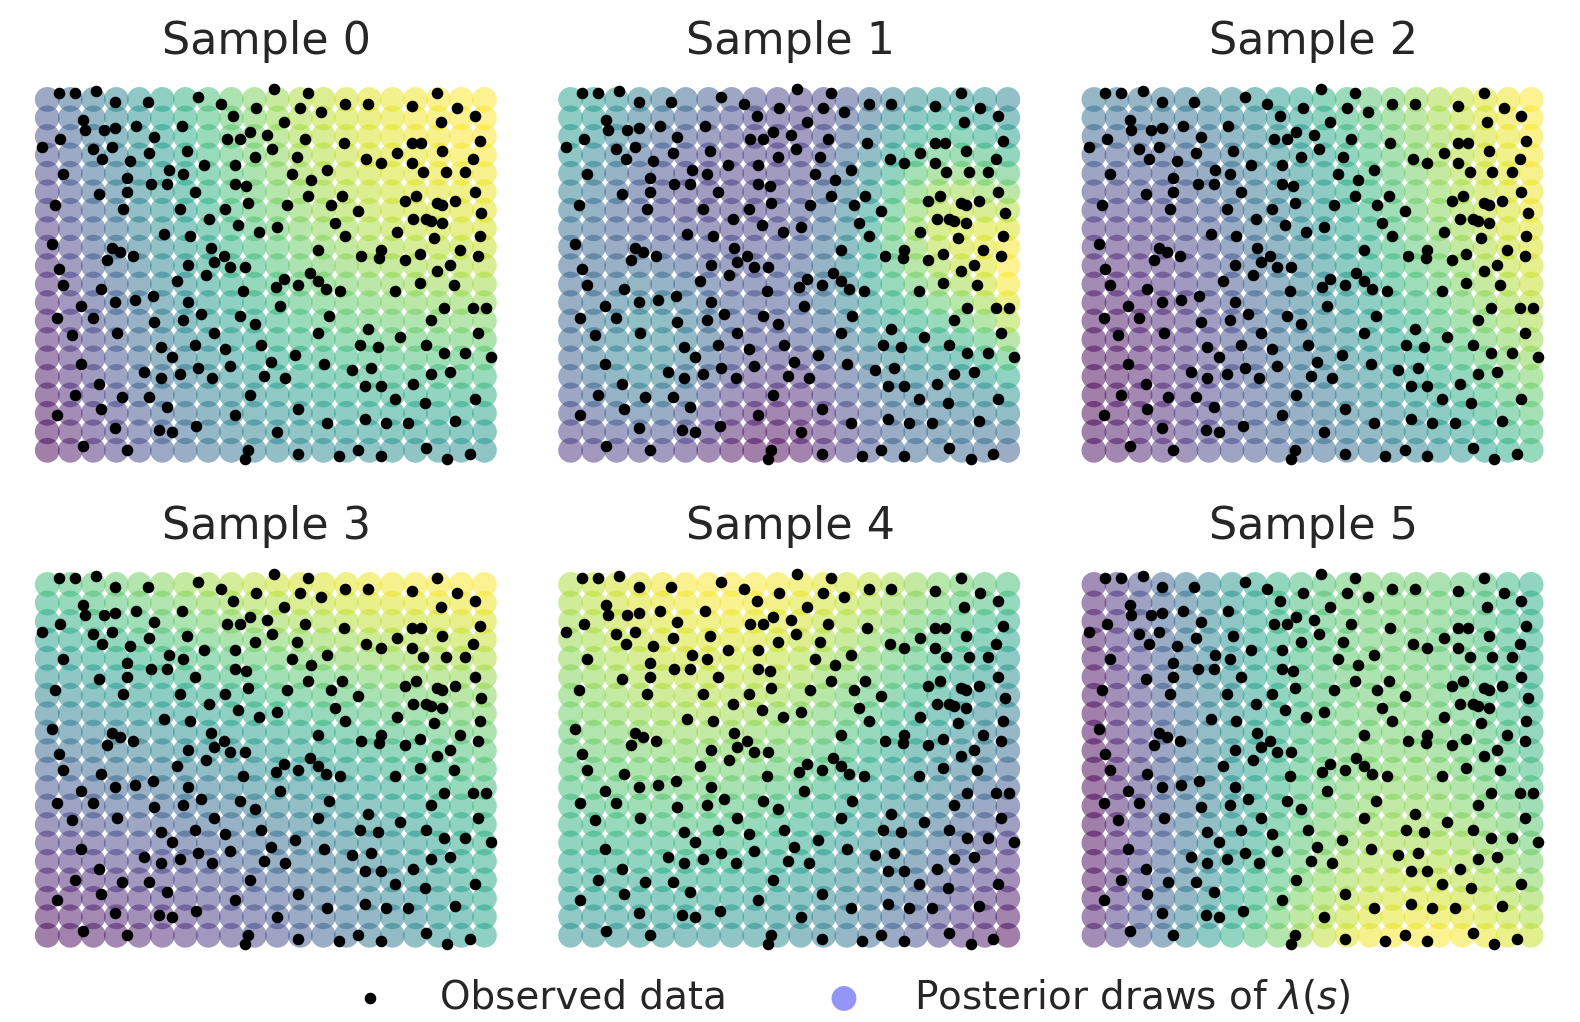

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 80}

for i in range(6):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=np.exp(intensity_samples[i]), **field_kwargs
    )

    obs_handle = axes[i].scatter(data["x"], data["y"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title("Sample {0}".format(i))

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", "Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False,
)

plt.tight_layout()

While there is some heterogeneity in the patterns these surfaces show, we obtain a posterior mean surface with a very clearly defined spatial surface with higher intensity in the upper right and lower intensity in the lower left.


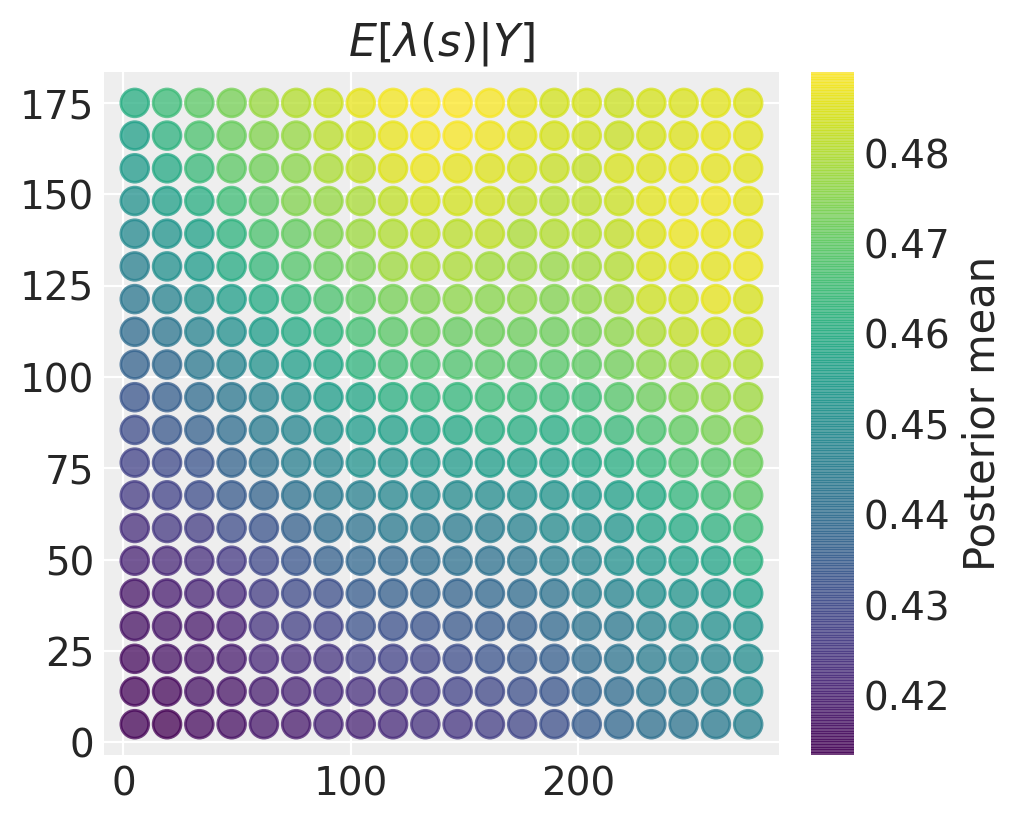

In [15]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=np.exp(intensity_samples).mean(axis=0),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

The spatial variation in our estimates of the intensity field may not be very meaningful if there is a lot of uncertainty. We can make a similar plot of the posterior variance (or standard deviation) in this case:

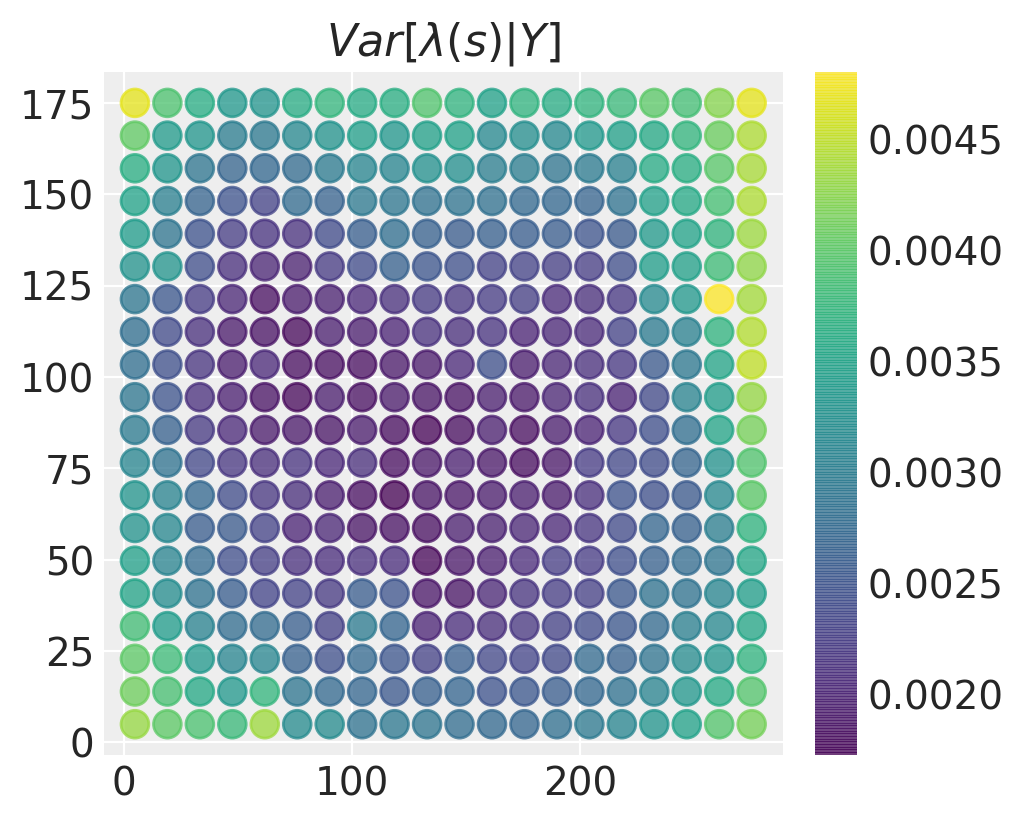

In [16]:
fig = plt.figure(figsize=(4, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=np.exp(intensity_samples).var(axis=0),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title("$Var[\lambda(s) \\vert Y]$"), plt.colorbar();

The posterior variance is lowest in the middle of the domain and largest in the corners and edges. This makes sense - in locations where there is more data, we have more accurate estimates for what the values of the intensity field may be.

# Extending the model to include marks

A shortcoming of the model from the previous section is that it is only modeling the number of points within a spatial domain and has no ability to represent the *mark* associated with each point. Here, the mark refers to the size of each anemone. We'll augment the model from the previous section to see whether the intensity field $\lambda(s)$ also has an impact on the anemone size. To do this, we will model the mark size as a linear function of the intensity field with a normal likelihood. This is nearly identical to the model described in [this paper](https://hal.archives-ouvertes.fr/hal-00622140/document) by Ho and Stoyan (2008).

The first part of the extended model is exactly as before save for the fact that we must evaluate the GP at not just the centroids of the grid cells but also at the location of each anemone. `augmented_coordinates` includes both of these sets of points in a single array.

In [17]:
augmented_coordinates = np.vstack([centroids, data[["x", "y"]].values])

n_centroids = centroids.shape[0]

with pm.Model() as mark_model:
    lam_mean = pm.Normal("lam_mean", sd=10)
    length_scale = pm.Uniform("length_scale", lower=0.1, upper=280)
    cov_scale = pm.Exponential("scale", lam=1)

    cov_func = cov_scale * pm.gp.cov.ExpQuad(2, ls=length_scale)
    mean_func = pm.gp.mean.Constant(lam_mean)
    intensity_gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = intensity_gp.prior("log_intensity", X=augmented_coordinates)
    intensity = pm.math.exp(log_intensity)

    rates = intensity[0:n_centroids] * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

We add on the next piece for the marks. Letting the marks be denoted by $z_i$, we use the following formula to represent $z_i$: 
$$z_i = \alpha +  \beta \lambda(s_i) + \epsilon_i$$
Then, standard priors are used for $\epsilon, \alpha, \beta$. The point of this model is to figure out whether or not the growth of the anemones is correlated with their occurrence. If we find that $\beta$ is negative, then that might hint that locations with more numerous anemones happen to also have smaller anemones and that competition for food may keep close neighbors small. 

In [18]:
with mark_model:
    alpha = pm.Normal("alpha", sd=10.0)
    beta = pm.Normal("beta", sd=5)
    eps_sd = pm.HalfCauchy("eps_sd", beta=1.0)

    mark_residuals = data["marks"].values - beta * intensity[n_centroids::] - alpha
    epsilon = pm.Normal("epsilon", sd=eps_sd, shape=n, observed=mark_residuals)

It is important to note that this model takes much longer to run because using MCMC with Gaussian processes as implemented here requires a covariance matrix inversion with cubic time complexity in the number of spatial points. Since this GP is fit over 357 spatial points instead of ~120 points as in the previous model, it could take roughly $3^3=27$ times as long. Inference could be sped up dramatically using a sparse Gaussian process if faster sampling is required.

In [19]:
with mark_model:
    trace = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_sd, beta, alpha, log_intensity_rotated_, scale, length_scale, lam_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17482 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


The posterior summaries indicate that most of the probability mass for $\beta$ is on negative values. This gives us a high posterior probability that the intensity field (i.e. the number of anemones) is anti-correlated with the size of each anemone!

In [20]:
with mark_model:
    summary_marks = pm.summary(trace, var_names=["alpha", "beta"])

summary_marks

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,6.000,0.901,4.531,7.795,0.026,0.019,1227.0,1120.0,1542.0,878.0,1.0
beta,-3.674,1.951,-7.610,-0.607,0.056,0.045,1229.0,951.0,1547.0,871.0,1.0


* This notebook was written by [Christopher Krapu](https://github.com/ckrapu) on September 6, 2020. 

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy  1.19.1
arviz  0.9.0
pandas 1.1.1
pymc3  3.9.3
last updated: Mon Sep 07 2020 

CPython 3.8.5
IPython 7.16.1
watermark 2.0.2
